In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import regularizers

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled)


## Linear auto-encoder : like PCA
### We get a linear model by removing activation functions

In [3]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print x_train.shape
print x_test.shape

(60000, 784)
(10000, 784)


In [6]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))

if True: # no sparsity constraint
    encoded = Dense(encoding_dim, activation=None)(input_img)
else:
    encoded = Dense(encoding_dim, activation=None,
                    activity_regularizer=regularizers.activity_l1(10e-5))(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation=None)(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

In [7]:
# train autoencoder to reconstruct MNIST digits
# use a per-pixel binary crossentropy loss
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [8]:
autoencoder.fit(x_train, x_train,
                nb_epoch=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 0s - loss: 0.4669 - val_loss: 0.3347
Epoch 2/50
60000/60000 [==============================] - 0s - loss: 0.3070 - val_loss: 0.2802
Epoch 3/50
60000/60000 [==============================] - 0s - loss: 0.2655 - val_loss: 0.2468
Epoch 4/50
60000/60000 [==============================] - 0s - loss: 0.2391 - val_loss: 0.2290
Epoch 5/50
60000/60000 [==============================] - 0s - loss: 0.2216 - val_loss: 0.2123
Epoch 6/50
60000/60000 [==============================] - 0s - loss: 0.2110 - val_loss: 0.2052
Epoch 7/50
60000/60000 [==============================] - 0s - loss: 0.2040 - val_loss: 0.1964
Epoch 8/50
60000/60000 [==============================] - 0s - loss: 0.1929 - val_loss: 0.1842
Epoch 9/50
60000/60000 [==============================] - 0s - loss: 0.1818 - val_loss: 0.1741
Epoch 10/50
60000/60000 [==============================] - 0s - loss: 0.1735 - val_loss: 0.1688

In [9]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

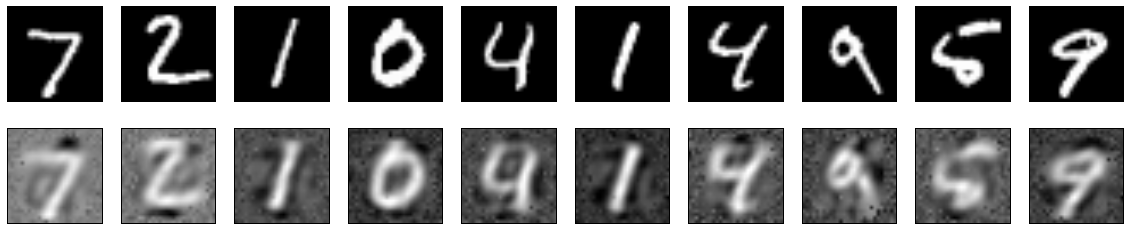

In [10]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()